In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

import util

## 4.1.1 Normal by Addition

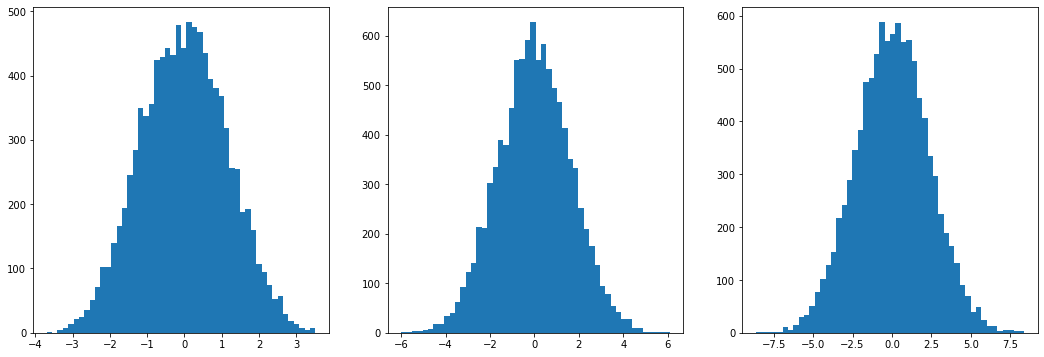

In [3]:
rng = np.random.RandomState(42)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, n_steps in enumerate([4, 8, 16]):
    pos = rng.uniform(-1, 1, size=(10000, n_steps))

    ax = axs[i]
    ax.hist(pos.sum(-1), bins=50)

# 4.3 Gaussian model of height

In [4]:
df = pl.read_csv("data/Howell1.csv", sep=";")
print(util.summarize(df))

pl.DataFrame of shape (544, 4)

╒══════════╤═════════╤════════════╤═══════════╤══════════╤══════════╤══════════════════╕
│ column   │ dtype   │       mean │       std │     5.5% │    94.5% │ histogram        │
╞══════════╪═════════╪════════════╪═══════════╪══════════╪══════════╪══════════════════╡
│ height   │ f64     │ 138.264    │ 27.6024   │ 81.1085  │ 165.735  │     ▁  ▁▁▁▁▄█▆▂  │
├──────────┼─────────┼────────────┼───────────┼──────────┼──────────┼──────────────────┤
│ weight   │ f64     │  35.6106   │ 14.7192   │  9.36072 │  54.5029 │ ▁▂▄▂▂▁▁▁▄▆█▇▅▃▁  │
├──────────┼─────────┼────────────┼───────────┼──────────┼──────────┼──────────────────┤
│ age      │ f64     │  29.3444   │ 20.7469   │  1       │  66.135  │ █▄▅▄▅▄▄▄▃▂▁▁▁    │
├──────────┼─────────┼────────────┼───────────┼──────────┼──────────┼──────────────────┤
│ male     │ i64     │   0.472426 │  0.499699 │  0       │   1      │ █              ▇ │
╘══════════╧═════════╧════════════╧═══════════╧══════════╧══════════╧═════════

In [5]:
d2 = df.filter(pl.col("age") >= 18)
print(util.summarize(d2))

pl.DataFrame of shape (352, 4)

╒══════════╤═════════╤═══════════╤═══════════╤══════════╤══════════╤══════════════════╕
│ column   │ dtype   │      mean │       std │     5.5% │    94.5% │ histogram        │
╞══════════╪═════════╪═══════════╪═══════════╪══════════╪══════════╪══════════════════╡
│ height   │ f64     │ 154.597   │  7.74233  │ 142.875  │ 167.005  │  ▁▃▄▆█▅▅▅▆▃▁▁    │
├──────────┼─────────┼───────────┼───────────┼──────────┼──────────┼──────────────────┤
│ weight   │ f64     │  44.9905  │  6.45671  │  35.1375 │  55.7659 │ ▁▁▄▄▅▆▆▅█▄▃▂▃    │
├──────────┼─────────┼───────────┼───────────┼──────────┼──────────┼──────────────────┤
│ age      │ f64     │  41.1385  │ 15.9679   │  20      │  70      │ ▆▅▇▄▄█▃▃▃▁▃▁▁    │
├──────────┼─────────┼───────────┼───────────┼──────────┼──────────┼──────────────────┤
│ male     │ i64     │   0.46875 │  0.499733 │   0      │   1      │ █              ▇ │
╘══════════╧═════════╧═══════════╧═══════════╧══════════╧══════════╧══════════════════╛


## 4.3.5 Finding the posterior distribution with quap

In [6]:
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2["height"].to_numpy())
svi_result = svi.run(jax.random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4420.39it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0389]


In [7]:
samples = m4_1.sample_posterior(jax.random.PRNGKey(1), p4_1, (10000,))
samples = pl.DataFrame({k: np.array(v) for k, v in samples.items()})
print(util.summarize(samples))

pl.DataFrame of shape (10000, 2)

╒══════════╤═════════╤═══════════╤══════════╤═══════════╤══════════╤══════════════════╕
│ column   │ dtype   │      mean │      std │      5.5% │    94.5% │ histogram        │
╞══════════╪═════════╪═══════════╪══════════╪═══════════╪══════════╪══════════════════╡
│ mu       │ f32     │ 154.609   │ 0.412593 │ 153.949   │ 155.269  │    ▁▂▅▇█▇▅▃▁     │
├──────────┼─────────┼───────────┼──────────┼───────────┼──────────┼──────────────────┤
│ sigma    │ f32     │   7.74556 │ 0.291966 │   7.28616 │   8.2254 │    ▂▄▆█▇▆▃▁      │
╘══════════╧═════════╧═══════════╧══════════╧═══════════╧══════════╧══════════════════╛


# 4.4 Linear Prediction

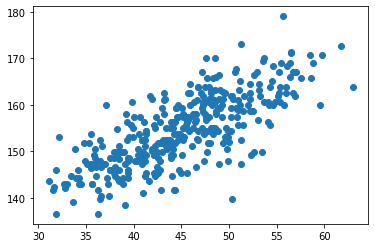

In [8]:
plt.scatter(d2["weight"], d2["height"])

In [9]:
mean_weight = d2["weight"].mean()

# Linear model for height given weight.
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - mean_weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2["weight"].to_numpy(),
    height=d2["height"].to_numpy(),
)
svi_result = svi.run(jax.random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3407.26it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297]


In [10]:
samples = m4_3.sample_posterior(jax.random.PRNGKey(1), p4_3, (1000,))
samples.pop("mu")  # Without this line the kernel hangs?!
samples = pl.DataFrame({k: np.array(v) for k, v in samples.items()})
print(util.summarize(samples))

pl.DataFrame of shape (1000, 3)

╒══════════╤═════════╤════════════╤═══════════╤═══════════╤═══════════╤══════════════════╕
│ column   │ dtype   │       mean │       std │      5.5% │     94.5% │ histogram        │
╞══════════╪═════════╪════════════╪═══════════╪═══════════╪═══════════╪══════════════════╡
│ a        │ f32     │ 154.619    │ 0.274087  │ 154.173   │ 155.043   │    ▁▂▃▄▇█▇▅▄▂▁   │
├──────────┼─────────┼────────────┼───────────┼───────────┼───────────┼──────────────────┤
│ b        │ f32     │   0.905715 │ 0.0426725 │   0.84007 │   0.9764  │    ▁▂▅▇█▆▄▂▁     │
├──────────┼─────────┼────────────┼───────────┼───────────┼───────────┼──────────────────┤
│ sigma    │ f32     │   5.08459  │ 0.194483  │   4.7908  │   5.41005 │    ▁▂▄▇▇█▆▄▂▁    │
╘══════════╧═════════╧════════════╧═══════════╧═══════════╧═══════════╧══════════════════╛


In [11]:
util.covariance(samples)

name,a,b,sigma
str,f64,f64,f64
"""a""",0.075123,-0.0001,0.001269
"""b""",-0.0001,0.001821,-0.000076
"""sigma""",0.001269,-0.000076,0.037823


Text(0, 0.5, 'height')

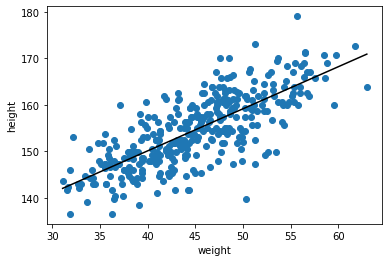

In [12]:
# Scatter plot of original data and line showing model parameter mean.
fig, ax = plt.subplots()
ax.scatter(d2["weight"], d2["height"])
x = np.linspace(d2["weight"].min(), d2["weight"].max(), 101)
ax.plot(x, samples["a"].mean() + samples["b"].mean() * (x - mean_weight), "k")

ax.set_xlabel("weight")
ax.set_ylabel("height")

In [13]:
weights = np.arange(start=d2["weight"].min(), stop=d2["weight"].max(), step=1)

# Compute mu for each sample from posterior and for each weight in weight_seq.
post = m4_3.sample_posterior(jax.random.PRNGKey(1), p4_3, (1000,))
mu_pred = Predictive(m4_3.model, post, return_sites=["mu"])
mu = mu_pred(jax.random.PRNGKey(2), weights, None)["mu"]
print(mu.shape)

(1000, 32)


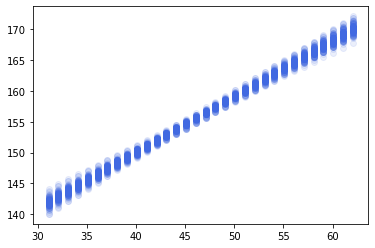

In [14]:
# Plot distribution of sampled mu values.
for i in range(100):
    plt.plot(weights, mu[i], "o", c="royalblue", alpha=0.1)

Text(0, 0.5, 'height')

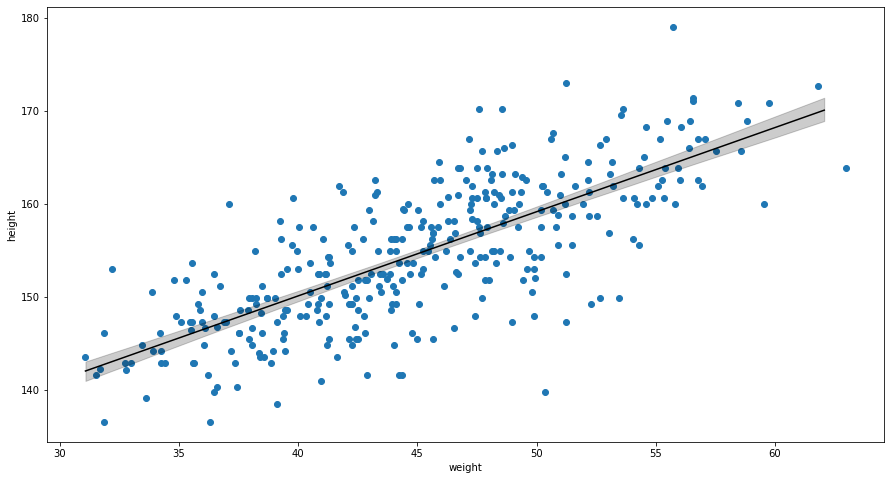

In [15]:
# Scatter plot of original data, line showing model parameter mean
# and shaded region showing confidence interval for the mean.

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(d2["weight"], d2["height"])
ax.plot(weights, mu.mean(axis=0), "k")

# Shaded region for confidence interval of mu.
mu_PI = np.percentile(mu, q=[5.5, 94.5], axis=0)
plt.fill_between(weights, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

ax.set_xlabel("weight")
ax.set_ylabel("height")

In [16]:
# Compute mu for each sample from posterior and for each weight in weight_seq.
post = m4_3.sample_posterior(jax.random.PRNGKey(1), p4_3, (10000,))
height_pred = Predictive(m4_3.model, post, return_sites=["height"])
height_samples = height_pred(jax.random.PRNGKey(2), weights, None)["height"]
print(height_samples.shape)

(10000, 32)


Text(0, 0.5, 'height')

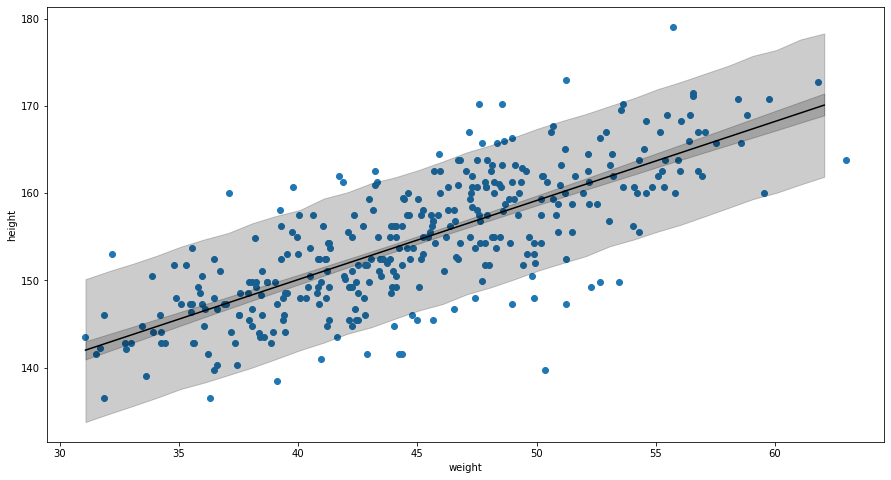

In [17]:
# Scatter plot of original data, line showing model parameter mean
# and shaded regions showing confidence interval for the mean and heights.

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(d2["weight"], d2["height"])
ax.plot(weights, mu.mean(axis=0), "k")

# Shaded region for confidence interval of mu.
mu_PI = np.percentile(mu, q=[5.5, 94.5], axis=0)
plt.fill_between(weights, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

# Shaded region for confidence interval of heights.
height_PI = np.percentile(height_samples, q=[5.5, 94.5], axis=0)
plt.fill_between(weights, height_PI[0], height_PI[1], color="k", alpha=0.2)

ax.set_xlabel("weight")
ax.set_ylabel("height")

# 4.5 Curves from Lines

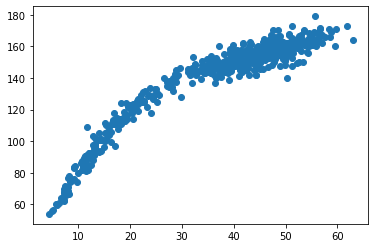

In [18]:
plt.scatter(df["weight"], df["height"])

In [19]:
weight_mean, weight_std = df["weight"].mean(), df["weight"].std()

# Linear model for height given weight.
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    c = numpyro.sample("c", dist.Normal(0, 1))
    weight_s = (weight - weight_mean) / weight_std
    weight_s2 = weight_s ** 2
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * weight_s + c * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_5,
    optim.Adam(0.3),
    Trace_ELBO(),
    weight=df["weight"].to_numpy(),
    height=df["height"].to_numpy(),
)
svi_result = svi.run(jax.random.PRNGKey(0), 3000)
p4_5 = svi_result.params

100%|██████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 5248.49it/s, init loss: 68267.6406, avg. loss [2851-3000]: 1770.2694]


In [20]:
samples = m4_5.sample_posterior(jax.random.PRNGKey(1), p4_5, (1000,))
samples.pop("mu")  # Without this line the kernel hangs?!
samples = pl.DataFrame({k: np.array(v) for k, v in samples.items()})
print(util.summarize(samples))

pl.DataFrame of shape (1000, 4)

╒══════════╤═════════╤═══════════╤══════════╤═══════════╤═══════════╤══════════════════╕
│ column   │ dtype   │      mean │      std │      5.5% │     94.5% │ histogram        │
╞══════════╪═════════╪═══════════╪══════════╪═══════════╪═══════════╪══════════════════╡
│ a        │ f32     │ 146.048   │ 0.362486 │ 145.472   │ 146.598   │   ▁▂▄▅▇█▆▆▄▂     │
├──────────┼─────────┼───────────┼──────────┼───────────┼───────────┼──────────────────┤
│ b        │ f32     │  21.7508  │ 0.295609 │  21.2728  │  22.2192  │    ▁▂▃▅▆█▆▅▃▂    │
├──────────┼─────────┼───────────┼──────────┼───────────┼───────────┼──────────────────┤
│ c        │ f32     │  -7.79229 │ 0.279089 │  -8.2499  │  -7.35573 │      ▁▂▅▆█▆▅▄▂▁  │
├──────────┼─────────┼───────────┼──────────┼───────────┼───────────┼──────────────────┤
│ sigma    │ f32     │   5.77912 │ 0.171185 │   5.50691 │   6.05139 │    ▂▃▅▆▇█▇▅▃▂    │
╘══════════╧═════════╧═══════════╧══════════╧═══════════╧═══════════╧════════

Text(0, 0.5, 'height')

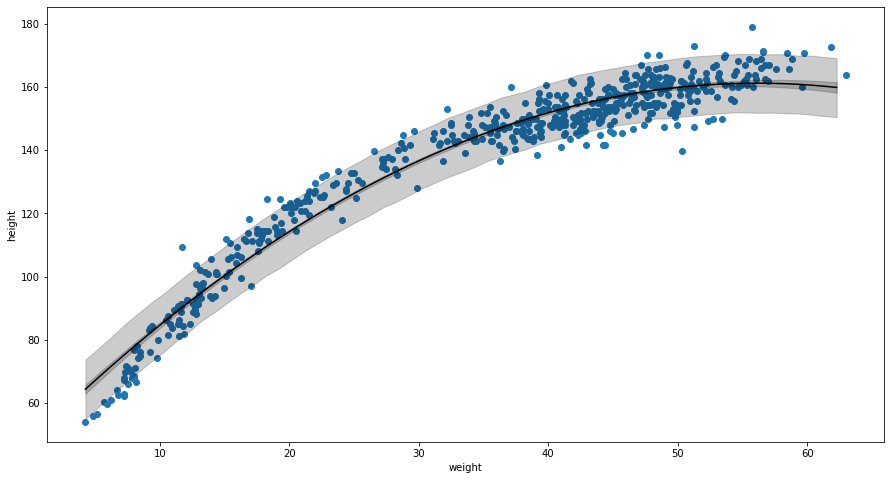

In [21]:
weights = np.arange(start=df["weight"].min(), stop=df["weight"].max(), step=1)

post = m4_5.sample_posterior(jax.random.PRNGKey(1), p4_5, (10000,))
pred = Predictive(m4_5.model, post, return_sites=["mu", "height"])
samples = pred(jax.random.PRNGKey(2), weights, None)

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(df["weight"], df["height"])
ax.plot(weights, samples["mu"].mean(axis=0), "k")

# Shaded region for confidence interval of mu.
mu_PI = np.percentile(samples["mu"], q=[5.5, 94.5], axis=0)
plt.fill_between(weights, mu_PI[0], mu_PI[1], color="k", alpha=0.2)

# Shaded region for confidence interval of heights.
height_PI = np.percentile(samples["height"], q=[5.5, 94.5], axis=0)
plt.fill_between(weights, height_PI[0], height_PI[1], color="k", alpha=0.2)

ax.set_xlabel("weight")
ax.set_ylabel("height")

## 4.5.2 Splines

In [22]:
hana = pl.read_csv("data/cherry_blossoms.csv", sep=";", null_values="NA")
print(util.summarize(hana))

pl.DataFrame of shape (1215, 5)

╒════════════╤═════════╤════════════╤════════════╤═══════════╤════════════╤══════════╤══════════════════╕
│ column     │ dtype   │       mean │        std │      5.5% │      94.5% │   % null │ histogram        │
╞════════════╪═════════╪════════════╪════════════╪═══════════╪════════════╪══════════╪══════════════════╡
│ year       │ i64     │ 1408       │ 350.885    │ 867.77    │ 1948.23    │  0       │ ███████▇████████ │
├────────────┼─────────┼────────────┼────────────┼───────────┼────────────┼──────────┼──────────────────┤
│ doy        │ i64     │  104.541   │   6.40704  │  94.43    │  115       │ 31.9342  │   ▁▁▂▅▄▅█▄▅▂▁    │
├────────────┼─────────┼────────────┼────────────┼───────────┼────────────┼──────────┼──────────────────┤
│ temp       │ f64     │    6.14189 │   0.663648 │   5.15    │    7.2947  │  7.48971 │  ▁▄▃▄▆█▆▃▃▂▁▁    │
├────────────┼─────────┼────────────┼────────────┼───────────┼────────────┼──────────┼──────────────────┤
│ temp_upper 

In [33]:
d2 = hana[hana["doy"].is_not_null()]
num_knots = 15
knot_list = np.quantile(d2["year"], q=np.linspace(0, 1, num=num_knots))

In [36]:
from scipy.interpolate import BSpline

knots = np.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=3)(d2["year"])

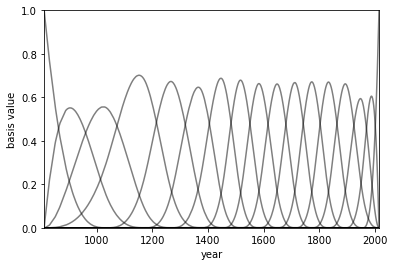

In [40]:
plt.subplot(
    xlim=(d2["year"].min(), d2["year"].max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2["year"].to_numpy(), B[:, i], "k", alpha=0.5)

In [42]:
def model(B, D):
    a = numpyro.sample("a", dist.Normal(100, 10))
    w = numpyro.sample("w", dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + B @ w)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


start = {"w": np.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2["doy"].to_numpy())
svi_result = svi.run(jax.random.PRNGKey(0), 20000)
p4_7 = svi_result.params

100%|███████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:01<00:00, 16880.01it/s, init loss: 2476234.5000, avg. loss [19001-20000]: 2705.3267]


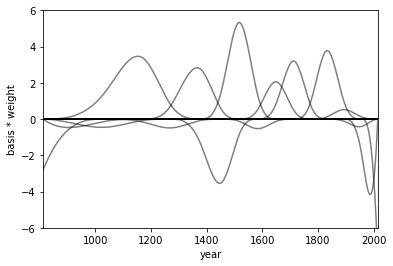

In [45]:
post = m4_7.sample_posterior(jax.random.PRNGKey(1), p4_7, (1000,))
w = np.mean(post["w"], 0)
plt.subplot(
    xlim=(d2["year"].min(), d2["year"].max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",
)
for i in range(B.shape[1]):
    plt.plot(d2["year"].to_numpy(), (w[i] * B[:, i]), "k", alpha=0.5)

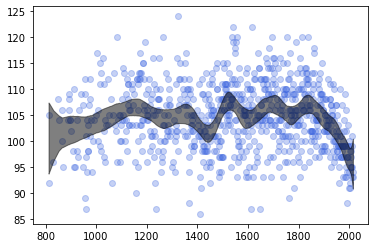

In [52]:
mu = post["mu"]
mu_PI = np.percentile(mu, q=np.array([1.5, 98.5]), axis=0)
plt.scatter(d2["year"], d2["doy"], alpha=0.3, c="royalblue")
plt.fill_between(d2["year"].to_numpy(), mu_PI[0], mu_PI[1], color="k", alpha=0.5)
plt.show()